# Initialize data

In [6]:
# initialize data 
###
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# plot table
import texttable as tt

def plotTable(headers,
              rows,
              valign=True,
              column_width=False,
              no_deco=False,
              precision=1):
    tab = tt.Texttable()
    if len(headers) > 0:
        tab.header(headers)
    tab.set_precision(precision)
    for row in rows:
        tab.add_row(row)

    if valign and len(headers) > 0:
        tab.set_cols_valign(['m'] * len(headers))

    if column_width:
        columns = [0] * len(rows[0])
        for row in rows:
            for i, cell in enumerate(row):
                if isinstance(row[i], str):
                    columns[i] = max(
                        columns[i],
                        max([len(line) for line in row[i].split('\n')]))
        for i, head in enumerate(headers):
            columns[i] = max(columns[i], len(head))
        tab.set_cols_width(columns)

    if no_deco:
        tab.set_deco(tt.Texttable.HEADER | tt.Texttable.VLINES)

    s = tab.draw()
    return s

def data_from_file(file_name,case):
    data = np.loadtxt(file_name)
    ids = data[0, :]    
    dfs = data[1:, :]
    iqs = list(range(180, -1, -10))
    xLabel = 'd-axis current - Id [A]'
    yLabel = 'Direct flux linkage [Wb]'
    Is = 'Iq '
    return ids, dfs, iqs, Is, xLabel, yLabel


ids, dfs, iqs, Is, xLabel, yLabel = data_from_file('D_d_madalina.txt',1 )


# Plot original curves

In [10]:
print(len(dfs))

19


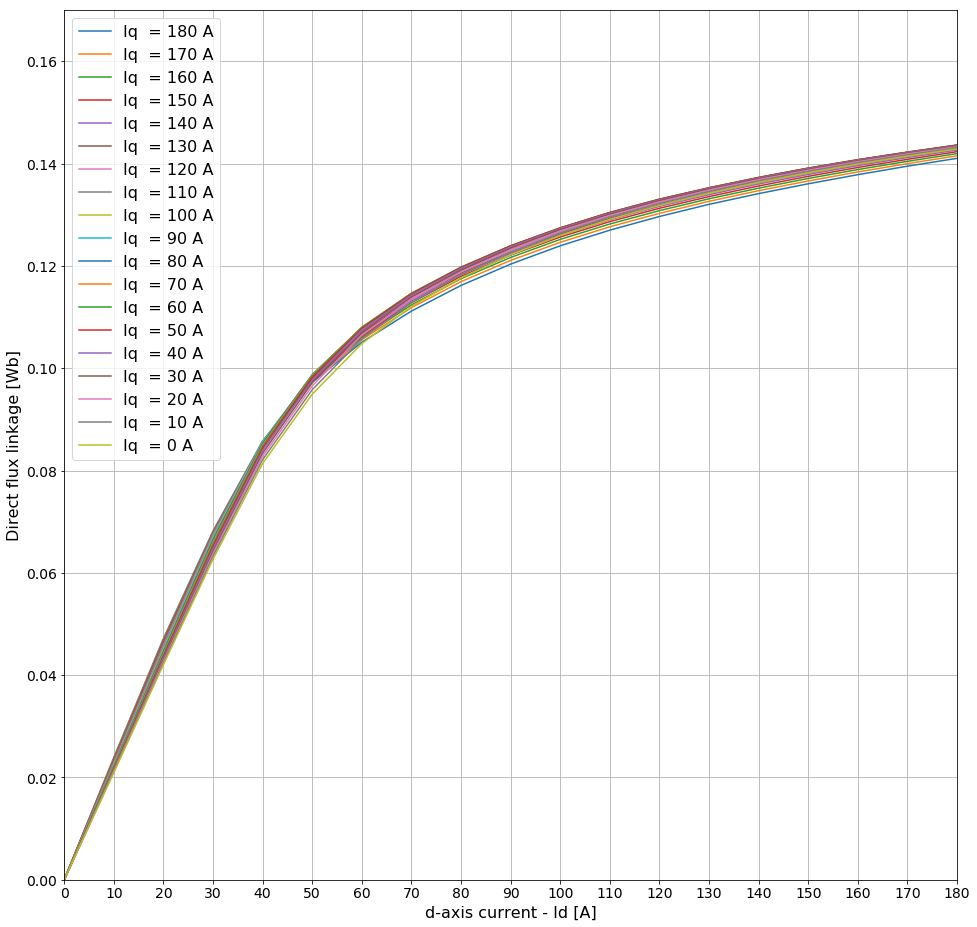

In [14]:
#

from subprocess import call
plt.clf()
plt.rcParams["figure.figsize"] = [16,16]
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14

curves = list(range(0,19))

for idx in curves:
    df = dfs[:, idx]
        
    plt.plot(ids, df, label='%s = %d A' %(Is,iqs[idx]))
    plt.ylim([0, 0.17])
    plt.xlim([0, 180])
    plt.xticks(ids)
    plt.xlabel(xLabel, fontsize = 16)
    plt.ylabel(yLabel, fontsize = 16)
    plt.legend(loc='best', fontsize = 16)
plt.grid()
plt.savefig('OriginalIqs.png', dpi = 300)
plt.show()

# PCA for reducing the number of Iq curves


# PCA to reduce the number of defining point (ids from Ox axis)

Ideas:

    Reduce the number of points, using PCA
    Pt. reconstructie:
        Spline pe nr redus de puncte
        Loss intre Spline si curbele initiale



In [12]:
#
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import interpolate
from sklearn.decomposition import PCA
from sklearn import preprocessing
from pandas import DataFrame as df

#INITIALIZE THE TABLE 
headers =[ 'No of PCs' ]+['Total Error'] + ['Id %d'%id for id in ids] 
rows    = []

#preprocess the data
flux = dfs.T
scaler = preprocessing.StandardScaler()
df_flux_scaled = scaler.fit_transform(flux)
weights  = []

avg_Iqs_weights_headers = ['Components'] + ['Iq %d' % iq for iq in ids]
avg_Iqs_weights_rows = []

no_of_comps = [2, 4, 6,8,9]
for comp in no_of_comps:
    row = [comp]
    pca_reduce_curves = PCA(n_components=comp)
    flux_reduced = pca_reduce_curves.fit_transform(df_flux_scaled)
    projected  = pca_reduce_curves.inverse_transform(flux_reduced)
    projected_unscaled = scaler.inverse_transform(projected)

    # # plot reconstructions
    # for curve in range(0, flux.shape[0], 4):
    #     plt.clf()
    #     plt.rcParams["figure.figsize"] = [12,8]
    #     plt.rcParams['xtick.labelsize']=12
    #     plt.rcParams['ytick.labelsize']=12
    #     plt.plot(x_new, flux[curve, :], label = 'original', color = 'black')
    #     plt.plot(x_new, projected_unscaled[curve, :], label = 'projected')
    #     plt.legend()
    #     plt.title('IQ: %d pca_comp: %d' % (iqs[curve], comp))
    #     plt.grid()
    #     plt.show() 

    
    # plot main components
    plt.clf()
    plt.rcParams["figure.figsize"] = [12,8]
    plt.rcParams['xtick.labelsize']=12
    plt.rcParams['ytick.labelsize']=12
    
    components = pca_reduce_curves.components_
    components = scaler.inverse_transform(components)
    
#     for idx in range(components.shape[0]):
#         plt.plot(ids, components[idx, :], label='Principal Component %d'%idx)
#         plt.xlabel(xLabel,fontsize=14)
#         plt.ylabel(yLabel,fontsize=14)
#         plt.legend(fontsize=12)  
#         plt.xticks(list(range(0, 240, 20)))
#         plt.xlim(0, 220)
#     plt.grid()
#     plt.savefig('TOP{}PrincipalComponents.png'.format(comp), dpi = 200)  
#     plt.show() 
    
    error = (flux - projected_unscaled) ** 2
    error = np.sum(error, axis=1)
    error = error.astype(np.float64) * (10 ** 6)
    row.append(sum(error))
    row = row + error.tolist() 
    
    rows.append(row)
    
    #table - meaning of PCs  
    headers_PC =[ 'Idx of PC' ] + ['Iq %d' % id for id in ids] 
    rows_PC    = []
    i = 1
    for component in pca_reduce_curves.components_:
        row_PC = [i]
        for value in component:
            row_PC.append(value)
        i+=1
        rows_PC.append(row_PC)
        
    # average contribution of each feature
    avg_weights = np.mean(abs(pca_reduce_curves.components_), axis=0)
    weights.append(avg_weights.tolist())
#     avg_weights_data. append()
    avg_Iqs_weights_rows.append([comp] + avg_weights.tolist())
    
# print PC meaning   
# print ("Meaning of the %d components(Weights for each IQ curve)"  %comp)
# table_PC = plotTable(headers=headers_PC, rows=rows_PC, column_width=True, precision=5) 
# print(table_PC)

# print errors in table    
# print('Loss ( sum squared error * 10 ^ 6)')
np_weights = np.asarray(weights, dtype=np.float32)

data = np_weights.T

df_weights = df(data = np.round(np_weights.T, 1), index = iqs, columns = no_of_comps)
print(df_weights)
df_weights.to_csv('average_weights_of_PCA_curves.csv')
print('Average contribution of each curve -- for diff num of components')
table = plotTable(avg_Iqs_weights_headers, avg_Iqs_weights_rows)
print(table)

       2    4    6    8    9
180  0.2  0.4  0.3  0.3  0.2
170  0.2  0.2  0.2  0.2  0.2
160  0.3  0.2  0.2  0.2  0.2
150  0.3  0.3  0.2  0.2  0.2
140  0.3  0.2  0.3  0.3  0.3
130  0.3  0.2  0.3  0.3  0.3
120  0.3  0.3  0.3  0.2  0.2
110  0.2  0.2  0.2  0.2  0.2
100  0.2  0.2  0.2  0.1  0.2
90   0.2  0.1  0.2  0.2  0.2
80   0.2  0.1  0.1  0.1  0.1
70   0.2  0.1  0.1  0.2  0.2
60   0.1  0.1  0.1  0.1  0.1
50   0.1  0.1  0.1  0.1  0.1
40   0.1  0.1  0.1  0.1  0.1
30   0.1  0.1  0.1  0.1  0.1
20   0.1  0.2  0.1  0.1  0.1
10   0.1  0.2  0.2  0.2  0.2
0    0.1  0.2  0.2  0.2  0.2
Average contribution of each curve -- for diff num of components


ValueError: max_width too low to render data

<Figure size 1152x1152 with 0 Axes>


# Ridge for PCA reducing points no - reducing Ids from OX

In [69]:
#
from sklearn.linear_model import Ridge
from pandas import DataFrame as df

X = dfs.T
y = list(ids)

model = Ridge(fit_intercept=True, normalize=True)
model.fit(X, y)

# best case 1, worst case -1, random prediction: 0
print('Regression train score: %.2f\n' % model.score(X, y))

components = pca_reduce_points.components_
components = scaler.inverse_transform(components)

#find upper and lower Iq curve
def border_curves(curve, interval):
    left = max([i for i in interval if i < curve])
    right = min([i for i in interval if i > curve])

    ## return index of left/right
    return interval.index(left), interval.index(right)

result = model.predict(components)
print('Predicted Ids (Ox axis coordinates): ')
csv_data = [[] for i in range(len(result))]
for i, pred in enumerate(result):
    left, right = border_curves(round(pred), y)
    print('PCA_comp %d <=> Id= %d A between (%d A, %d A)' % (i, round(pred), y[left], y[right]))
    csv_data[i].append(round(pred))
    csv_data[i].append(y[left])
    csv_data[i].append(y[right])

df_pred = df(data= csv_data)

Regression train score: 0.98

Predicted Ids (Ox axis coordinates): 
PCA_comp 0 <=> Id= 80 A between (70 A, 90 A)
PCA_comp 1 <=> Id= 104 A between (100 A, 110 A)
PCA_comp 2 <=> Id= 91 A between (90 A, 100 A)
PCA_comp 3 <=> Id= 90 A between (80 A, 100 A)
PCA_comp 4 <=> Id= 90 A between (80 A, 100 A)
PCA_comp 5 <=> Id= 90 A between (80 A, 100 A)
PCA_comp 6 <=> Id= 90 A between (80 A, 100 A)
PCA_comp 7 <=> Id= 90 A between (80 A, 100 A)
PCA_comp 8 <=> Id= 90 A between (80 A, 100 A)
PCA_comp 9 <=> Id= 90 A between (80 A, 100 A)
PCA_comp 10 <=> Id= 90 A between (80 A, 100 A)
PCA_comp 11 <=> Id= 90 A between (80 A, 100 A)
PCA_comp 12 <=> Id= 90 A between (80 A, 100 A)
PCA_comp 13 <=> Id= 90 A between (80 A, 100 A)
PCA_comp 14 <=> Id= 90 A between (80 A, 100 A)
PCA_comp 15 <=> Id= 90 A between (80 A, 100 A)
PCA_comp 16 <=> Id= 90 A between (80 A, 100 A)
PCA_comp 17 <=> Id= 90 A between (80 A, 100 A)
PCA_comp 18 <=> Id= 90 A between (80 A, 100 A)
